# Relativistic Shallow Water Equations

The Harpole Relativistic Shallow Water Equations (HrSWE) are (in one dimensional form, suitable for the Riemann Problem)
$$
  \partial_t \begin{pmatrix} \Phi W \\ \Phi W^2 u_j \end{pmatrix} + \partial_x \begin{pmatrix} \Phi W u^i \\ \Phi W^2 u_j u^i + \tfrac{1}{2} \Phi^2 \delta^i_j \end{pmatrix} = {\bf 0}.
$$
This can also be written
$$
  \partial_t \begin{pmatrix} D \\ S_j \end{pmatrix} + \partial_x \begin{pmatrix} D u^i \\ S_j u^i + \frac{D^2}{2 W^2} \delta^i_j \end{pmatrix} = {\bf 0}.
$$
Remember that $W^{-2} = 1 - u_j u^j$.

We will assume one dimensional motion and a plane or spherical background, so we only need $g_{xx} = 1 = g^{xx}$. Using
$$
  \frac{S^2}{D^2} = W^2 u^2
$$
we get
$$
  u^2 = \frac{S^2}{S^2 + D^2}
$$
and hence
$$
  W^{-2} = \frac{D^2}{S^2 + D^2}
$$
with $u_j = S_j / (D W)$ following.

We now drop the ${}_j$ subscript, as we are working in one dimension, and start working out the Jacobian.

In [1]:
import sympy
sympy.init_printing()

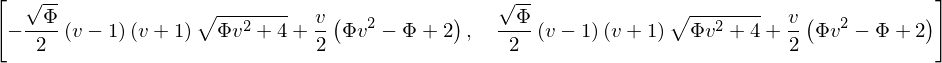

In [2]:
phi = sympy.symbols('Phi', positive=True)
v = sympy.symbols('v')
W = 1 / sympy.sqrt(1 - v**2)
D = phi * W
S = phi * W**2 * v
fD = D * v
fS = S * v + phi**2 / 2

q = sympy.Matrix([D, S])
w = [phi, v]
dqdw = q.jacobian(w)
flux = sympy.Matrix([fD, fS])
dfdw = flux.jacobian(w)
J = dqdw.inv()*dfdw

evals = list(J.eigenvals().keys())
evals

We see that the eigenvalues are messy, compared to the Newtonian limit. Let's check that in the Newtonian limit ($\Phi$ *and* $v$ small) we get the expected result:

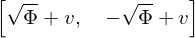

In [3]:
evals_Newtonian = evals.copy()
for i, e in enumerate(evals_Newtonian):
    evals_Newtonian[i] = e.series(v, 0, 2).removeO().series(phi, 0, 1).removeO()
evals_Newtonian

We also check that the "acoustic" speed is the same in the relativistic case:

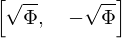

In [4]:
evals_v_zero = evals.copy()
for i, e in enumerate(evals_v_zero):
    evals_v_zero[i] = e.subs(v, 0).simplify()
evals_v_zero

So the advective and acoustic wavespeeds have the same interpretation: however, the relativistic addition of the $v$ and $\sqrt{\phi}$ parts complicates the full nonlinear wavespeeds.

We will need the eigenvalues later in code form. Let us create functions for them:

In [5]:
import numpy
evals_m_sp = sympy.lambdify((phi, v), evals[1], modules='numpy')
evals_p_sp = sympy.lambdify((phi, v), evals[0], modules='numpy')

We also need the equation for the primitive variables across the rarefaction wave. We note that
$$
  \frac{\partial}{\partial \xi} \left( \begin{pmatrix} \Phi \\ u \end{pmatrix} \right) = \frac{ {\bf r} }{ \nabla_{\bf w} \lambda \cdot {\bf r} }
$$
where $\lambda, {\bf r}$ are the appropriate eigenvalue and right eigenvector for this wave (either associated with the positive or negative sign) and ${\bf w} = (\Phi, v)^T$ are the primitive variables.

Later on we are going to solve across the wave up to a given value of $\Phi$. *In this case*, as the system has size $2$, we can rewrite the equation as
$$
  \frac{\partial u}{\partial \Phi} = \frac{\partial u}{\partial \xi} \left( \frac{\partial u}{\partial \xi} \right)^{-1}.
$$

Let's compute this:

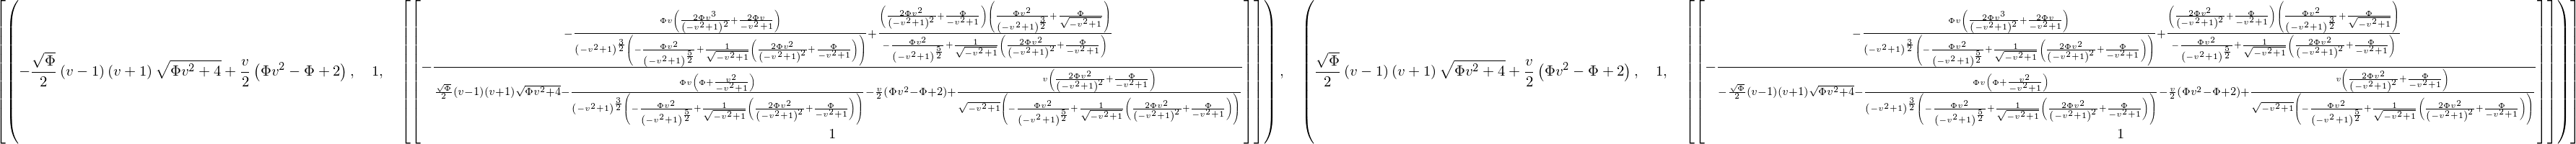

In [6]:
evecs = J.eigenvects()
evecs

The order may not match the eigenvalues previously computed, so we re-do the eigenvalues using slightly changed notation:

In [7]:
lam_m = evecs[1][0]
lam_p = evecs[0][0]
r_m = sympy.Matrix(evecs[1][2][0])
r_p = sympy.Matrix(evecs[0][2][0])

divisor_m = sympy.Matrix([lam_m]).jacobian(w).dot(r_m)
rhs_m = r_m / divisor_m.simplify()
rhs_single_m = (rhs_m[1] / rhs_m[0]).simplify()

divisor_p = sympy.Matrix([lam_p]).jacobian(w).dot(r_p)
rhs_p = r_p / divisor_p.simplify()
rhs_single_p = (rhs_p[1] / rhs_p[0]).simplify()

In [8]:
lam_p.subs(v, 0)

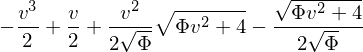

In [9]:
rhs_single_m

We see that these equations aren't too bad, but they'd be a pain to solve analytically. Instead we create functions to solve them numerically.

In [10]:
rhs_m_sp = sympy.lambdify((phi, v), rhs_single_m, modules='numpy')
rhs_p_sp = sympy.lambdify((phi, v), rhs_single_p, modules='numpy')

From these functions we can now solve across a rarefaction wave. We will assume that we're dealing with a dam-break problem where the known data has $v=0$ and we have $\Phi_L > \Phi_R$. Thus we expect the left wave to be a rarefaction and the right a shock. We will root find to construct $\Phi_*$, which means we guess $\Phi_*$ and then solve across the rarefaction and the shock to get guesses for $v_*$: when the guesses agree we have a solution.

The solution across the rarefaction can be found using `scipy` functions:

In [11]:
from scipy.integrate import odeint
from scipy.optimize import brentq, newton, root

def raref_m_rhs(v, phi):
    return rhs_m_sp(phi, v)

def rarefaction(w, phi_star, n_phi_vals=2):
    phi, v = w
    phi_points = numpy.linspace(phi, phi_star, n_phi_vals)
    lam_l = evals_m_sp(phi, v)
    v_raref = odeint(raref_m_rhs, v, phi_points)
    return v_raref

The solution across a shock can also be found using `scipy` functions. We now assume that $\Phi_*$ is given and root-find to solve the Rankine-Hugoniot conditions for the shock velocity $V_s$ and for $v_*$.

In [12]:
def shock_residual(guess, w, phi_star):
    Vs, v_star = guess
    phi, v = w
    W = 1 / numpy.sqrt(1 - v**2)
    W_star = 1 / numpy.sqrt(1 - v_star**2)
    q = numpy.array([phi * W, phi * W**2 * v])
    q_star = numpy.array([phi_star * W_star, phi_star * W_star**2 * v_star])
    f = numpy.array([phi * W * v, phi * W**2 * v**2 + (phi**2) / 2])
    f_star = numpy.array([phi_star * W_star * v_star, phi_star * W_star**2 * v_star**2 + (phi_star**2) / 2])
    residual = Vs * (q - q_star) - (f - f_star)
    return residual

We can combine this to write a general dam-break solver. First write a function to find $\Phi_*$:

In [13]:
def phi_residual(phi_star, wl, wr, Vs_hard_guess):
    # Solve across the rarefaction
    v_star_raref = rarefaction(wl, phi_star)[-1]
    # Guess the shock speed
    if Vs_hard_guess is None:
        Vs_guess = 0.9*evals_p_sp(phi_star, v_star_raref)
    else:
        Vs_guess = Vs_hard_guess
    #print('guess', evals_p_sp(phi_star, v_star_raref), evals_p_sp(*wr), Vs_guess)
    shock_result = root(shock_residual, [Vs_guess, v_star_raref], args=(wr, phi_star))
    #print(shock_result)
    v_star_shock = shock_result.x[1]
    
    return v_star_raref - v_star_shock

Then put it all together:

In [14]:
def dam_break(phi_l, phi_r,  xi_min=-1, xi_max=1, Vs_hard_guess=None):
    assert phi_l > phi_r
    wl = [phi_l, 0]
    wr = [phi_r, 0]
    # Find phi_star
    phi_star = brentq(phi_residual, phi_l, phi_r, args=(wl, wr, Vs_hard_guess))
    
    # Left state
    lams = [xi_min]
    phis = [wl[0]]
    vs = [wl[1]]
    # Find rarefaction tail
    lam_l = evals_m_sp(*wl)
    lams.append(lam_l)
    phis.append(wl[0])
    vs.append(wl[1])
    # Solve down rarefaction
    phi_raref = numpy.linspace(wl[0], phi_star)
    v_raref = rarefaction(wl, phi_star, len(phi_raref))
    #print(v_raref)
    for i, p in enumerate(phi_raref):
        lams.append(evals_m_sp(p, v_raref[i]))
        phis.append(p)
        vs.append(v_raref[i])
    # Find shock result
    #print(vs)
    v_star = v_raref[-1]
    if Vs_hard_guess is None:
        Vs_guess = 0.9*evals_p_sp(phi_star, v_star)
    else:
        Vs_guess = Vs_hard_guess
    shock_result = root(shock_residual, [Vs_guess, v_star], args=(wr, phi_star))
    #print(shock_result)
    Vs = shock_result.x[0]
    lams.append(Vs)
    phis.append(phi_star)
    vs.append(v_star)
    lams.append(Vs)
    phis.append(wr[0])
    vs.append(wr[1])
    #    Right state
    lams.append(xi_max)
    phis.append(wr[0])
    vs.append(wr[1])
    
    return lams, phis, vs

Check it on some cases:

In [15]:
%matplotlib inline
from matplotlib import pyplot

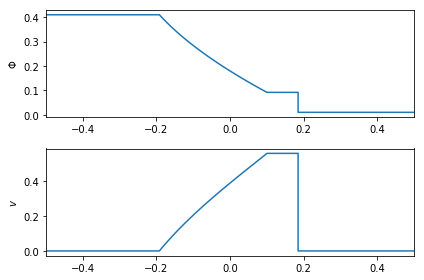

In [16]:
t_end = 0.3
domain = (-0.5, 0.5)
phi_l = 0.41
phi_r = 0.01
lams, phis, vs = dam_break(phi_l, phi_r, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

/anaconda/envs/jupyterlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


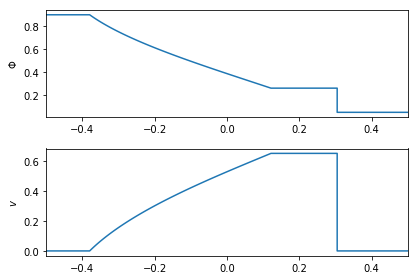

In [17]:
t_end = 0.4
domain = (-0.5, 0.5)
phi_l = 0.90
phi_r = 0.05
lams, phis, vs = dam_break(phi_l, phi_r, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end, Vs_hard_guess=0.8)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

/anaconda/envs/jupyterlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


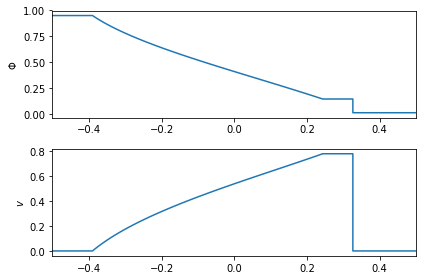

In [18]:
t_end = 0.4
domain = (-0.5, 0.5)
phi_l = 0.95
phi_r = 0.01
lams, phis, vs = dam_break(phi_l, phi_r, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end, Vs_hard_guess=0.9)

fig, ax = pyplot.subplots(2, 1)
ax[0].plot(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

/anaconda/envs/jupyterlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


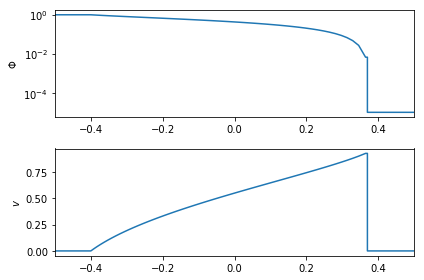

In [19]:
t_end = 0.4
domain = (-0.5, 0.5)
phi_l = 0.9999
phi_r = 0.00001
lams, phis, vs = dam_break(phi_l, phi_r, xi_min=domain[0] / t_end, xi_max=domain[1] / t_end, Vs_hard_guess=0.999)

fig, ax = pyplot.subplots(2, 1)
ax[0].semilogy(t_end * numpy.array(lams), phis)
ax[0].set_ylabel(r"$\Phi$")
ax[0].set_xlim(*domain)
ax[1].plot(t_end * numpy.array(lams), vs)
ax[1].set_ylabel(r"$v$")
ax[1].set_xlim(*domain)
fig.tight_layout()

It seems to be very difficult to get high velocities ($v_* > 0.95$, for example). This may indicate a solver problem in this regime (not sure I'd trust the numerical solution there either).